    This file is a part of the lor_neuro_rat project.
    Copyright (C) 2019 anonimous

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

    Please contact with me by E-mail: shkolnick.kun@gmail.com

In [47]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import h5py

import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import gc
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate, Flatten
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
#from keras.layers import CuDNNLSTM, CuDNNGRU

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.callbacks import Callback
from keras import optimizers
from keras.layers import Lambda

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords

import os
#os.environ['OMP_NUM_THREADS'] = '4'

#from unidecode import unidecode

import time
%matplotlib inline

# Сформируем датасет

In [82]:
df = pd.read_pickle('data/XyWrdTok1.pkl')

                         TopId             MsgId                      Creator  \
0        /forum/talks/12648516  comment-12649855      /people/mandala/profile   
1        /forum/talks/10056125  comment-10056157        /people/dvrts/profile   
2        /forum/talks/11903900  comment-11904141   /people/kiverattes/profile   
3        /forum/talks/12103367  comment-12103408   /people/alexferman/profile   
4  /forum/development/10968185  comment-10968212  /people/Progressive/profile   

                            Time                             SrcLink  \
0  2016-06-07T20:01:40.393+03:00  /forum/talks/12648516?cid=12649823   
1  2014-01-15T14:47:38.711+04:00                                       
2  2015-08-29T22:59:17.271+03:00  /forum/talks/11903900?cid=11904067   
3  2015-11-12T08:57:55.115+03:00  /forum/talks/12103367?cid=12103402   
4  2014-10-24T20:08:29.646+04:00                                       

                                           DelReason  \
0  Сообщение удалено по 

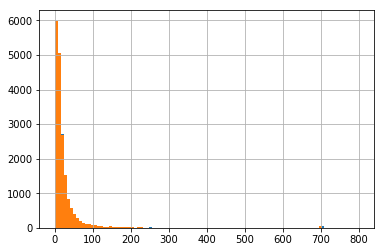

In [83]:
print(df.head())
print(df.describe())
df['TokCnt'].hist(bins=100)
df['WrdCnt'].hist(bins=100)

# Подготовка имбеддингов

In [84]:
y = df['Use'].values
X = [' '.join(tokens) for tokens in list(df['Tokens'])]

In [85]:
print(X[0])
print(X[1000])
print(y[0])
print(y[15000])

уровень развитие цивилизация лишь смотреть потомок крутить палец висок иметь значение ерунда вопрос страшно жить восклицание
ещё известно остаться девелоперский состав россия фон коньюнктура последний месяц прибыль компания деньга зп обезьяна платить национальный фантик расширить штат
1
0


In [100]:
#Приделываем токенайзер из keras
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
print(len(tokenizer.word_index))

43652


In [101]:
wrds = []
idxs = []
for w, i in tokenizer.word_index.items():
    wrds.append(w)
    idxs.append(i)
    
if 'ебаный' in wrds:
    print(idxs[wrds.index('ебаный')])

1998


In [102]:
#Сохраняем токенайзер
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [103]:
#Грузим токенайзер
with open('models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [104]:
max_len = 150
X_seq = tokenizer.texts_to_sequences(X)
X_seq_pad = pad_sequences(X_seq, maxlen=max_len)

In [105]:
h5f = h5py.File('data/Xy.h5', 'w')
print(h5f.create_dataset('X_seq_pad', data=X_seq_pad))
print(h5f.create_dataset('y', data=y))
h5f.close()

<HDF5 dataset "X_seq_pad": shape (18546, 150), type "<i4">
<HDF5 dataset "y": shape (18546,), type "<i8">


In [106]:
h5f = h5py.File('data/Xy.h5', 'r')
X_seq_pad = h5f['X_seq_pad'][:]
y         = h5f['y'][:]
h5f.close()
print(X_seq_pad.shape)
print(y.shape)

(18546, 150)
(18546,)


In [107]:
#Вычисляем матрицу весов слоя имбеддингов
from pymagnitude import *
import gensim

mg = Magnitude('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.magnitude')
ft = gensim.models.fasttext.FastText.load('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model')

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words,300))

for word, i in word_index.items():
    #
    if i >= max_features: 
        continue
    #
    #embedding_matrix[i] = mg.query(word)
    try:
        embedding_matrix[i] = ft.wv[word]
    except:
        embedding_matrix[i] = mg.query(word)
    

In [108]:
#Сохраняем матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'w')
print(h5f.create_dataset('EmbeddingMtx', data=embedding_matrix))
h5f.close()

<HDF5 dataset "EmbeddingMtx": shape (20000, 300), type "<f8">


In [109]:
#Грузим матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'r')
embedding_matrix = h5f['EmbeddingMtx'][:]
h5f.close()

In [110]:
print(mg.most_similar(embedding_matrix[41]))

[('хотеть', 2.812577320686599), ('хотеться', 2.3983779776585212), ('захотеть', 2.3109008004426967), ('хочеться', 2.137105026629015), ('захотеться', 2.1296900961666765), ('желать', 2.0487689728235736), ('хочеть', 1.9573280464992098), ('терпеться', 1.9293542529854362), ('мечтать', 1.8906516129757023), ('думать', 1.8665639303883852)]


In [111]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, cv_iter=0, arch=0):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val, self.Weigths = validation_data
        self.max_score = 0
        self.not_better_count = 0
        self._cv_iter = cv_iter
        self._arch = arch

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1, batch_size=512)
            score = roc_auc_score(self.y_val, y_pred, sample_weight=self.Weigths)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
                model.save("models/best_model_%d_%d.h5"%(int(self._arch),int(self._cv_iter)))
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 3:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [138]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 0
def get_model(clipvalue=1.,num_filters=32,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(dropout)(x)
    
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, x_c, max_pool])
    
    x = Dropout(dropout)(x)
    
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [112]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 1
nn_arch = 1
def get_model(clipvalue=1.,num_filters=64,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(dropout)(x)
    
    # Тут мы получаем конкатенацию LSTM по двум направлениям 
    # плюс Hidden state и Cell state по двум направлениям
    x, x_a, x_b, x_c, x_d = Bidirectional(LSTM(num_filters, return_sequences=True, return_state = True))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_a, x_b, x_c, x_d, max_pool])
    
    x = Dropout(dropout)(x)
    
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [115]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 2
nn_arch = 3
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, x_c, max_pool])
    
    x = Dropout(dropout)(x)
    
    # Layer 6: output dense layer.
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [46]:
#Model 3
nn_arch = 4
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = Dense(num_filters, activation="relu")(x)
    
    x = Flatten()(x)
    # Layer 6: output dense layer.
    outp = Dense(1, activation="linear")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [139]:
print('Model:' , nn_arch)
#model = get_model()

batch_size = 512

# Used epochs=100 with early exiting for best score.
epochs = 100
gc.collect()
K.clear_session()

# Change to 4
num_folds = 5 #number of folds

#Приводим типы
y = np.array(y)

#Веса примеров, "меняем местами" 1 и 0
w_0 = 1/np.sum((y == 0.0).astype('float'))
w_1 = 1.0/np.sum((y == 1.0).astype('float'))
w = w_0*(y == 0.0).astype('float') + w_1*(y == 1.0).astype('float')
w /= np.sum(w)
w *= len(y)

kf = KFold(n_splits=num_folds, shuffle=True)

i = 0
for train_index, test_index in kf.split(X):
    
    gc.collect()
    K.clear_session()
    
    y_train = y[train_index] 
    y_test  = y[test_index]
    
    X_train = X_seq_pad[train_index]
    X_test  = X_seq_pad[test_index]
    
    w_train = w[train_index]
    w_test  = w[test_index]
    
    model = get_model()
    
    ra_val = RocAucEvaluation(validation_data=(X_test, y_test, w_test), interval = 1, cv_iter=i, arch=nn_arch)
    
    model.fit(X_train, y_train, sample_weight=w_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = [ra_val])
    
    y_t = load_model("models/best_model_%d_%d.h5"%(int(nn_arch),int(i))).predict(X_test, verbose=1, batch_size=512)
    y_a = (y_t>0.5).astype('float').reshape(y_test.shape)
    
    print('==== Weghtted scores ====')
    print('   Acc:', accuracy_score(y_test, y_a, sample_weight=w_test))
    print('  Prec:', precision_score(y_test, y_a, sample_weight=w_test))
    print('Recall:', recall_score(y_test, y_a, sample_weight=w_test))
    print('    F1:', f1_score(y_test, y_a, sample_weight=w_test))
    print('RocAuc:', roc_auc_score(y_test, y_t, sample_weight=w_test))

    print('==== Scores ====')
    print('   Acc:', accuracy_score(y_test, y_a))
    print('  Prec:', precision_score(y_test, y_a))
    print('Recall:', recall_score(y_test, y_a))
    print('    F1:', f1_score(y_test, y_a))
    print('RocAuc:', roc_auc_score(y_test, y_t))

    print('================')
    print('FP:', np.sum((y_a != y_test).astype('float')*y_a))
    print('FN:', np.sum((y_a != y_test).astype('float')*y_test))
    print('TP:', np.sum((y_a == y_test).astype('float')*y_a))
    print('TN:', np.sum((y_a == y_test).astype('float')*(1-y_test)))
    
    gc.collect()
    
    i += 1

print("Done")

Model: 0
Epoch 1/100
3710/3710 [==============================] - 1s 265us/step

 ROC-AUC - epoch: 1 - score: 0.747602 

*** New High Score (previous: 0.000000) 

Epoch 2/100
3710/3710 [==============================] - 1s 180us/step

 ROC-AUC - epoch: 2 - score: 0.782786 

*** New High Score (previous: 0.747602) 

Epoch 3/100
3710/3710 [==============================] - 1s 180us/step

 ROC-AUC - epoch: 3 - score: 0.806579 

*** New High Score (previous: 0.782786) 

Epoch 4/100
3710/3710 [==============================] - 1s 181us/step

 ROC-AUC - epoch: 4 - score: 0.813855 

*** New High Score (previous: 0.806579) 

Epoch 5/100
3710/3710 [==============================] - 1s 181us/step

 ROC-AUC - epoch: 5 - score: 0.818622 

*** New High Score (previous: 0.813855) 

Epoch 6/100
3710/3710 [==============================] - 1s 180us/step

 ROC-AUC - epoch: 6 - score: 0.821346 

*** New High Score (previous: 0.818622) 

Epoch 7/100
3710/3710 [==============================] - 1s 181us/s

3710/3710 [==============================] - 1s 181us/step

 ROC-AUC - epoch: 34 - score: 0.844416 

*** New High Score (previous: 0.843462) 

Epoch 35/100
3710/3710 [==============================] - 1s 179us/step

 ROC-AUC - epoch: 35 - score: 0.844553 

*** New High Score (previous: 0.844416) 

Epoch 36/100
3710/3710 [==============================] - 1s 178us/step

 ROC-AUC - epoch: 36 - score: 0.844953 

*** New High Score (previous: 0.844553) 

Epoch 37/100
3710/3710 [==============================] - 1s 179us/step

 ROC-AUC - epoch: 37 - score: 0.845528 

*** New High Score (previous: 0.844953) 

Epoch 38/100
3710/3710 [==============================] - 1s 178us/step

 ROC-AUC - epoch: 38 - score: 0.844750 

Epoch 39/100
3710/3710 [==============================] - 1s 178us/step

 ROC-AUC - epoch: 39 - score: 0.843761 

Epoch 40/100
3710/3710 [==============================] - 1s 180us/step

 ROC-AUC - epoch: 40 - score: 0.845270 

Epoch 41/100
3710/3710 [=======================

3709/3709 [==============================] - 1s 179us/step

 ROC-AUC - epoch: 13 - score: 0.824213 

*** New High Score (previous: 0.823990) 

Epoch 14/100
3709/3709 [==============================] - 1s 247us/step

 ROC-AUC - epoch: 14 - score: 0.826010 

*** New High Score (previous: 0.824213) 

Epoch 15/100
3709/3709 [==============================] - 1s 292us/step

 ROC-AUC - epoch: 15 - score: 0.826888 

*** New High Score (previous: 0.826010) 

Epoch 16/100
3709/3709 [==============================] - 1s 271us/step

 ROC-AUC - epoch: 16 - score: 0.827647 

*** New High Score (previous: 0.826888) 

Epoch 17/100
3709/3709 [==============================] - 1s 283us/step

 ROC-AUC - epoch: 17 - score: 0.828568 

*** New High Score (previous: 0.827647) 

Epoch 18/100
3709/3709 [==============================] - 1s 285us/step

 ROC-AUC - epoch: 18 - score: 0.829432 

*** New High Score (previous: 0.828568) 

Epoch 19/100
3709/3709 [==============================] - 1s 282us/step

 ROC

3709/3709 [==============================] - 1s 226us/step

 ROC-AUC - epoch: 46 - score: 0.844618 

*** New High Score (previous: 0.844557) 

Epoch 47/100
3709/3709 [==============================] - 1s 277us/step

 ROC-AUC - epoch: 47 - score: 0.843755 

Epoch 48/100
3709/3709 [==============================] - 1s 327us/step

 ROC-AUC - epoch: 48 - score: 0.844372 

Epoch 49/100
3709/3709 [==============================] - 1s 280us/step

 ROC-AUC - epoch: 49 - score: 0.843174 

Epoch 50/100
3709/3709 [==============================] - 1s 244us/step

 ROC-AUC - epoch: 50 - score: 0.845018 

*** New High Score (previous: 0.844618) 

Epoch 51/100
3709/3709 [==============================] - 1s 284us/step

 ROC-AUC - epoch: 51 - score: 0.843729 

Epoch 52/100
3709/3709 [==============================] - 1s 250us/step

 ROC-AUC - epoch: 52 - score: 0.844018 

Epoch 53/100
3709/3709 [==============================] - 1s 315us/step

 ROC-AUC - epoch: 53 - score: 0.843728 

Epoch 54/100
3709

3709/3709 [==============================] - 1s 338us/step

 ROC-AUC - epoch: 24 - score: 0.830360 

*** New High Score (previous: 0.830007) 

Epoch 25/100
3709/3709 [==============================] - 1s 293us/step

 ROC-AUC - epoch: 25 - score: 0.830476 

*** New High Score (previous: 0.830360) 

Epoch 26/100
3709/3709 [==============================] - 1s 369us/step

 ROC-AUC - epoch: 26 - score: 0.831392 

*** New High Score (previous: 0.830476) 

Epoch 27/100
3709/3709 [==============================] - 1s 289us/step

 ROC-AUC - epoch: 27 - score: 0.830384 

Epoch 28/100
3709/3709 [==============================] - 1s 323us/step

 ROC-AUC - epoch: 28 - score: 0.832530 

*** New High Score (previous: 0.831392) 

Epoch 29/100
3709/3709 [==============================] - 1s 314us/step

 ROC-AUC - epoch: 29 - score: 0.834318 

*** New High Score (previous: 0.832530) 

Epoch 30/100
3709/3709 [==============================] - 1s 194us/step

 ROC-AUC - epoch: 30 - score: 0.832306 

Epoch

3709/3709 [==============================] - 1s 250us/step

 ROC-AUC - epoch: 12 - score: 0.832752 

*** New High Score (previous: 0.829480) 

Epoch 13/100
3709/3709 [==============================] - 1s 300us/step

 ROC-AUC - epoch: 13 - score: 0.833323 

*** New High Score (previous: 0.832752) 

Epoch 14/100
3709/3709 [==============================] - 1s 336us/step

 ROC-AUC - epoch: 14 - score: 0.834379 

*** New High Score (previous: 0.833323) 

Epoch 15/100
3709/3709 [==============================] - 1s 272us/step

 ROC-AUC - epoch: 15 - score: 0.833899 

Epoch 16/100
3709/3709 [==============================] - 1s 284us/step

 ROC-AUC - epoch: 16 - score: 0.835939 

*** New High Score (previous: 0.834379) 

Epoch 17/100
3709/3709 [==============================] - 1s 290us/step

 ROC-AUC - epoch: 17 - score: 0.836664 

*** New High Score (previous: 0.835939) 

Epoch 18/100
3709/3709 [==============================] - 1s 275us/step

 ROC-AUC - epoch: 18 - score: 0.837590 

*** N

Epoch 16/100
3709/3709 [==============================] - 1s 200us/step

 ROC-AUC - epoch: 16 - score: 0.821932 

Epoch 17/100
3709/3709 [==============================] - 1s 218us/step

 ROC-AUC - epoch: 17 - score: 0.823225 

Epoch 18/100
3709/3709 [==============================] - 1s 239us/step

 ROC-AUC - epoch: 18 - score: 0.824396 

*** New High Score (previous: 0.824093) 

Epoch 19/100
3709/3709 [==============================] - 1s 247us/step

 ROC-AUC - epoch: 19 - score: 0.824294 

Epoch 20/100
3709/3709 [==============================] - 1s 323us/step

 ROC-AUC - epoch: 20 - score: 0.826122 

*** New High Score (previous: 0.824396) 

Epoch 21/100
3709/3709 [==============================] - 1s 234us/step

 ROC-AUC - epoch: 21 - score: 0.827709 

*** New High Score (previous: 0.826122) 

Epoch 22/100
3709/3709 [==============================] - 1s 270us/step

 ROC-AUC - epoch: 22 - score: 0.829017 

*** New High Score (previous: 0.827709) 

Epoch 23/100
3709/3709 [==========

# Типичные метрики на кросс-валидации
По разым значениям соотношения TP/TN в датасете
## 1/1
Weghtted scores:
 *    Acc: 0.76
 *   Prec: 0.77
 * Recall: 0.73
 *     F1: 0.75
 * RocAuc: 0.84

Scores
 *    Acc: 0.76
 *   Prec: 0.77
 * Recall: 0.74
 *     F1: 0.75
 * RocAuc: 0.84

## 1/2
## 1/5
## 1/10
## 1/20
## Все данные

In [141]:
y_all = load_model('models/best_model_0_0.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all += load_model('models/best_model_0_1.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all += load_model('models/best_model_0_2.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all += load_model('models/best_model_0_3.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all += load_model('models/best_model_0_4.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all /= 5.0#2.0*np.average(y_all)

18546/18546 [==============================] - 4s 215us/step


In [142]:
#y_t = (y_all>1.0*np.average(y_all)).astype('float').reshape(y.shape)
y_t = (y_all>0.5).astype('float').reshape(y.shape)

#print('==== Weghtted scores ====')
#print('   Acc:', accuracy_score(y, y_t, sample_weight=w))
#print('  Prec:', precision_score(y, y_t, sample_weight=w))
#print('Recall:', recall_score(y, y_t, sample_weight=w))
#print('    F1:', f1_score(y, y_t, sample_weight=w))
#print('RocAuc:', roc_auc_score(y, y_t, sample_weight=w))

print('==== Scores ====')
print('   Acc:', accuracy_score(y, y_t))
print('  Prec:', precision_score(y, y_t))
print('Recall:', recall_score(y, y_t))
print('    F1:', f1_score(y, y_t))
print('RocAuc:', roc_auc_score(y, y_all))

print('================')
print('FP:', np.sum((y_t != y).astype('float')*y_t))
print('FN:', np.sum((y_t != y).astype('float')*y))
print('TP:', np.sum((y_t == y).astype('float')*y_t))
print('TN:', np.sum((y_t == y).astype('float')*(1-y)))
print('N: ', len(X))

==== Scores ====
   Acc: 0.7995794241345843
  Prec: 0.8102524011614921
Recall: 0.7823789496387361
    F1: 0.7960717616722445
RocAuc: 0.8841247476160454
FP: 1699.0
FN: 2018.0
TP: 7255.0
TN: 7574.0
N:  18546


In [143]:
df.describe()

,Score,Class,Use,WrdCnt,TokCnt
count,18546.000000,18546.000000,18546.000000,18546.000000,18546.000000
mean,-1.531813,2.291599,0.500000,24.235091,24.168554
std,2.693769,2.929669,0.500013,52.183979,52.384457
min,-20.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.000000,0.000000,0.000000,6.000000,6.000000
50%,0.000000,0.500000,0.500000,12.000000,12.000000
75%,0.000000,5.000000,1.000000,24.000000,24.000000
max,0.000000,16.000000,1.000000,800.000000,797.000000


In [144]:
df['FN'] = y*(y_t != y).astype('float')
df['FP'] = y_t*(y_t != y).astype('float')

In [145]:
df_fp = df[df['FP'] == 1.0]

In [146]:
df_fp.describe()

,Score,Class,Use,WrdCnt,TokCnt,FN,FP
count,1699.0,1699.0,1699.0,1699.000000,1699.000000,1699.0,1699.0
mean,0.0,0.0,0.0,24.075927,23.931725,0.0,1.0
std,0.0,0.0,0.0,35.637482,35.443813,0.0,0.0
min,0.0,0.0,0.0,1.000000,1.000000,0.0,1.0
25%,0.0,0.0,0.0,7.000000,7.000000,0.0,1.0
50%,0.0,0.0,0.0,13.000000,13.000000,0.0,1.0
75%,0.0,0.0,0.0,26.000000,25.000000,0.0,1.0
max,0.0,0.0,0.0,474.000000,473.000000,0.0,1.0


In [147]:
df_fp.to_pickle('data/Xy_fp.pkl')
df_fp.to_excel('data/Xy_fp.xlsx')

In [148]:
df_fn = df[df['FN'] == 1.0]

In [149]:
df_fn.to_pickle('data/Xy_fn.pkl')
df_fn.to_excel('data/Xy_fn.xlsx')